,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


DATASET PROFILE
Shape: 517 rows × 14 columns
Memory usage: 0.10 MB

Column Types:
float64    9
int64      3
object     2

Numeric Columns Summary:


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,517.0,259.00,149.39,1.0,130.00,259.00,388.00,517.00
X,517.0,4.67,2.31,1.0,3.00,4.00,7.00,9.00
Y,517.0,4.30,1.23,2.0,4.00,4.00,5.00,9.00
FFMC,469.0,90.58,5.70,18.7,90.20,91.60,92.80,96.20
DMC,496.0,111.20,64.01,1.1,70.80,108.30,141.58,291.30
DC,474.0,550.67,246.06,7.9,441.20,664.50,713.90,860.60
ISI,515.0,9.02,4.56,0.0,6.45,8.40,10.75,56.10
temp,496.0,18.88,5.75,2.2,15.48,19.30,22.72,33.30
RH,487.0,44.38,16.18,15.0,33.00,42.00,53.50,100.00
wind,482.0,4.02,1.79,0.4,2.70,4.00,4.90,9.40


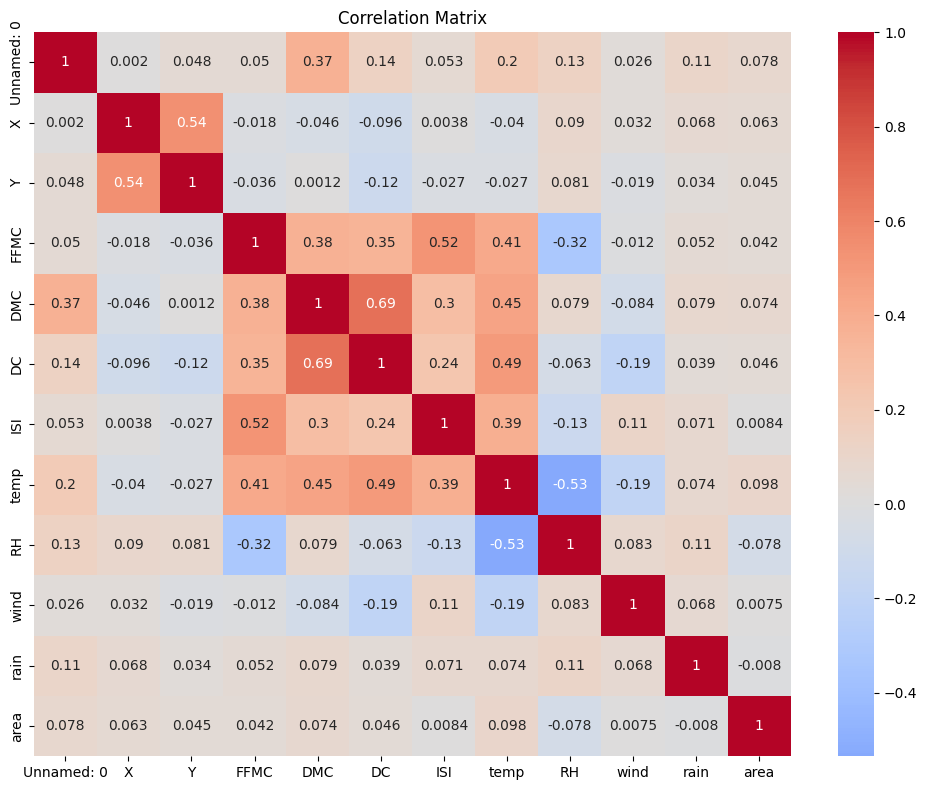


Categorical Columns:
  month: 12 unique values
    Top values: {'aug': 184, 'sep': 172, 'mar': 54, 'jul': 32, 'feb': 20}
  day: 7 unique values
    Top values: {'sun': 95, 'fri': 85, 'sat': 84, 'mon': 74, 'tue': 64}

Missing Values:


,count,percent
FFMC,48,9.3
DMC,21,4.1
DC,43,8.3
ISI,2,0.4
temp,21,4.1
RH,30,5.8
wind,35,6.8
rain,32,6.2


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

# Load dataset
fires_df = pd.read_csv('fires.csv')

def quick_profile(df: pd.DataFrame) -> None:
    """
    Generate a quick profile of a pandas DataFrame.
    
    Args:
        df (pd.DataFrame): Input dataset.
    """
    print("DATASET PROFILE")
    print("=" * 60)

    # --- Basic info ---
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    # --- Column types ---
    print("\nColumn Types:")
    print(df.dtypes.value_counts().to_string())

    # --- Numeric summary ---
    numeric_cols = df.select_dtypes(include="number").columns
    if numeric_cols.any():
        print("\nNumeric Columns Summary:")
        display(df[numeric_cols].describe().T.round(2))  # nicer table in Jupyter

        if len(numeric_cols) > 2:
            _plot_correlation_heatmap(df[numeric_cols])

    # --- Categorical summary ---
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns
    if categorical_cols.any():
        print("\nCategorical Columns:")
        for col in categorical_cols:
            unique_count = df[col].nunique(dropna=True)
            print(f"  {col}: {unique_count} unique values")

            value_counts = df[col].value_counts(dropna=False)
            if unique_count <= 20:
                print(f"    Top values: {dict(value_counts.head(5))}")
            else:
                print(f"    Most common: {value_counts.index[0]} ({value_counts.iloc[0]})")

    # --- Missing values ---
    missing = df.isnull().sum()
    if missing.any():
        print("\nMissing Values:")
        missing_df = (
            missing[missing > 0]
            .to_frame("count")
            .assign(percent=lambda x: (x["count"] / len(df) * 100).round(1))
        )
        display(missing_df)

# ---------- Helper Function ----------

def _plot_correlation_heatmap(df_num: pd.DataFrame) -> None:
    """Show a correlation heatmap inline in Jupyter."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_num.corr(), annot=True, cmap="coolwarm", center=0)
    plt.title("Correlation Matrix")
    plt.tight_layout()
    plt.show()

display(fires_df.head())
quick_profile(fires_df)

## Forest Fires Dataset

The dataset used in this project comes from the [UCI Machine Learning Repository – Forest Fires Dataset](https://archive.ics.uci.edu/dataset/162/forest+fires).  
It contains information about forest fires in the Montesinho Natural Park (Portugal) and the meteorological conditions under which they occurred.  
The goal is to predict the **burned area of the forest (in hectares)** given environmental and weather-related features.

---

### Dataset Overview
- **Rows (observations):** 517  
- **Columns (features):** 12 + 1 target variable (`area`)  
- **Target Variable:** `area` – burned forest area (in hectares)  

---

### Column Descriptions

1. & 2. **X, Y** – Spatial coordinates (grid location within the Montesinho park map).
3. **month** – Month of the year (`jan`–`dec`).
4. **day** – Day of the week (`mon`–`sun`).

- **Fire Weather Index (FWI) System Variables**  
These indices come from the **Canadian Forest Fire Weather Index (FWI) System**, widely used in fire danger assessment:  
5. **FFMC (Fine Fuel Moisture Code)** – Indicates the moisture content of surface litter and small vegetation; affects fire ignition probability (range: 18.7–96.2).  
6. **DMC (Duff Moisture Code)** – Reflects the moisture of decomposed organic material (duff) beneath the surface; represents medium-term fire potential (range: 1.1–291.3).  
7. **DC (Drought Code)** – Measures long-term dryness in deep, compact organic soil layers; affects fire sustainability (range: 7.9–860.6).  
8. **ISI (Initial Spread Index)** – Combines wind and FFMC to represent the expected fire spread rate at ignition (range: 0.0–56.1).

- **Weather Conditions**  
9. **temp** – Temperature in Celsius (2.2–33.3 °C).  
10. **RH (Relative Humidity)** – Percentage of air moisture (15–100%).  
11. **wind** – Wind speed in km/h (0.4–9.4 km/h).  
12. **rain** – Rainfall in mm/m² (0.0–6.4).  

- **Target Variable**  
13. **area** – Burned forest area (in hectares). Skewed heavily toward zero; most fires are small, but some extreme events exceed 1,000 ha.  

---

### Missing Values
Several features contain missing entries (e.g., `FFMC`, `DMC`, `DC`, `ISI`, `temp`, `RH`, `wind`, `rain`), which need to be handled during preprocessing.


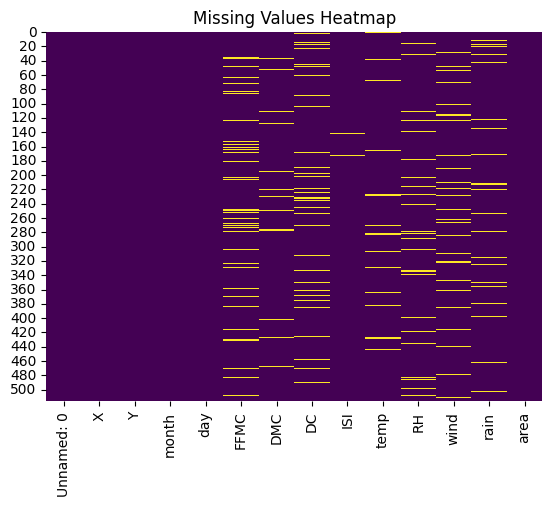

In [2]:
sns.heatmap(fires_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

In [4]:
fires_df.columns

Index(['Unnamed: 0', 'X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI',
       'temp', 'RH', 'wind', 'rain', 'area'],
      dtype='object')